In [1]:
from functools import reduce
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from numpy import sin as S
from numpy import cos as C
from math import atan2, sqrt
from math import pi
from matrices import *

In c:\users\iguru\documents\venv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In c:\users\iguru\documents\venv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In c:\users\iguru\documents\venv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In c:\users\iguru\documents\venv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In c:\users\iguru\documents\venv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
d1 = 10
a2 = 20

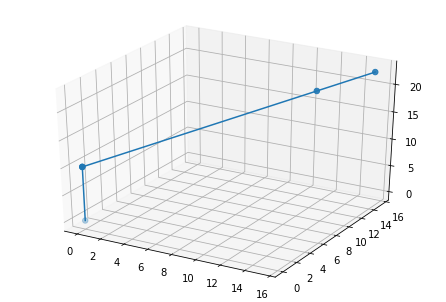

In [3]:
def fk(params, vis=True):
    """
    Returns transformation matrix
    """
    [q1,q2,d3] = params
    
    trans = [Rz(q1), Tz(d1), Ry(-q2), Tx(a2), Tx(d3)]
    
    res = trans[0]
    points = [res[0:3, 3].flatten()]
    for t in trans[1:]:
        res = res @ t
        points.append(res[0:3, 3].flatten())
        
    H = res
    
#     # Just one of general cases
#     if abs(H[0,2]) != 1:
#         r = atan2(H[2,1], H[2,2])
#         p = atan2(-H[2,1], sqrt(H[0,0]**2 + H[1,0]**2))
#         y = atan2(H[1,0], H[0,0])
#     else:
#         print("Singular case")
#         return
    
    points = np.array(points)

    if vis:
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.scatter(points[:,0],points[:,1],points[:,2],s=30)
        ax.plot(points[:,0],points[:,1],points[:,2])
        plt.show()

    return H[:3,3].flatten()

Q = [pi/4,pi/6,5]
xyz = fk(Q)

In [4]:
def ik(xyz):
    [x,y,z] = xyz
    r = sqrt(x**2 + y**2)
    s = z - d1
    q1 = atan2(y,x)
    q2 = atan2(s,r)
    d3 = sqrt(r**2 + s**2) - a2
    return np.array([q1,q2,d3])
    
all(np.isclose(Q, ik(xyz)))

True

In [5]:
def J_deriv(Q):
    [q1,q2,d3] = Q
    J = np.eye(3,3)
    C1 = C(q1)
    C2 = C(q2)
    S1 = S(q1)
    S2 = S(q2)
    
    j11 = -(a2+d3)*S1*C2
    j12 = (a2+d3)*C1*S2
    j13 = C1*C2
    
    j21 = (a2+d3)*C1*C2
    j22 = (a2+d3)*S1*S2
    j23 = S1*C2
    
    j31 = 0
    j32 = -(a2+d3)*C2
    j33 = S2
    
    return np.array([
                    [j11,j12,j13],
                    [j21,j22,j23],
                    [j31,j32,j33],
                    [0,-S1,0],
                    [0,C1,0],
                    [1,0,0],
                   ])
j1 = J_deriv(Q)
# j1 = J_deriv([0,0,0,])

j1

array([[-15.30931089,   8.83883476,   0.61237244],
       [ 15.30931089,   8.83883476,   0.61237244],
       [  0.        , -21.65063509,   0.5       ],
       [  0.        ,  -0.70710678,   0.        ],
       [  0.        ,   0.70710678,   0.        ],
       [  1.        ,   0.        ,   0.        ]])

In [6]:
def J_num(Q):
    [q1,q2,d3] = Q
    trans = [Rz(q1), Tz(d1), Ry(-q2), Tx(a2), Tx(d3)]
    
    res = trans[0]
    for t in trans[1:]:
        res = res @ t
        
    H = np.array(res)
    
    R = H[:3,:3]
    R_inv = expand_rotation(np.linalg.inv(R))
    J1r = [dRz(q1), Tz(d1), Ry(-q2), Tx(a2), Tx(d3), R_inv]
    J2r = [Rz(q1), Tz(d1), dRy(-q2), Tx(a2), Tx(d3), R_inv]
    J3r = [Rz(q1), Tz(d1), Ry(-q2), Tx(a2), dTx(d3), R_inv]
    
    J1r = reduce(lambda a,b: a@b, J1r)
    J2r = reduce(lambda a,b: a@b, J2r)
    J3r = reduce(lambda a,b: a@b, J3r)
    
    J1 = np.array([J1r[0,3], J1r[1,3], J1r[2,3], J1r[2,1], J1r[0,2], J1r[1,0]])
    J2 = np.array([J2r[0,3], J2r[1,3], J2r[2,3], J2r[2,1], J2r[0,2], J2r[1,0]])
    J3 = np.array([J3r[0,3], J3r[1,3], J3r[2,3], J3r[2,1], J3r[0,2], J3r[1,0]])
    
    return np.array([J1,J2,J3]).T

j2 = J_num(Q)
# j2 = J_num([0,0,0,])

j2

array([[-1.53093109e+01,  8.83883476e+00,  6.12372436e-01],
       [ 1.53093109e+01,  8.83883476e+00,  6.12372436e-01],
       [ 0.00000000e+00, -2.16506351e+01,  5.00000000e-01],
       [ 0.00000000e+00, -7.07106781e-01,  0.00000000e+00],
       [ 2.89136486e-17,  7.07106781e-01,  0.00000000e+00],
       [ 1.00000000e+00,  5.45524131e-17,  0.00000000e+00]])

In [7]:
all(np.isclose(j1,j2).flatten())

True

In [8]:
def J_geom(Q):
    [q1,q2,d3] = Q
    trans = [Rz(q1), Tz(d1), 'O', Ry(-q2), Tx(a2), 'O', Tx(d3), 'O']
    
    res = trans[0]
    Ts = [np.eye(4,4)]
    for t in trans[1:]:
        if t == 'O':
            Ts.append(res)
            continue
        res = res @ t
    
    T00 = Ts[0]
    T01 = Ts[1]
    T02 = Ts[2]
    T03 = Ts[3]
    
    Z0 = T00[:3,2] # Rz
    Z1 = T01[:3,1] # Ry
    Z2 = T02[:3,0] # Tx
    
    O3 = T03[:3,3]
    O2 = T02[:3,3]
    O1 = T01[:3,3]
    O0 = T00[:3,3]
    
    J1 = np.concatenate([np.cross(Z0, (O3 - O0)), Z0]).reshape(-1,1)
    J2 = np.concatenate([np.cross(Z1, (O3 - O1)), Z1]).reshape(-1,1)
    J3 = np.concatenate([Z2, [0,0,0]]).reshape(-1,1)
    
    return np.concatenate([J1,J2,J3], axis=1)
    
    
j3 = J_geom(Q)

j3

c:\users\iguru\documents\venv\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


array([[-15.30931089,   8.83883476,   0.61237244],
       [ 15.30931089,   8.83883476,   0.61237244],
       [  0.        , -21.65063509,   0.5       ],
       [  0.        ,  -0.70710678,   0.        ],
       [  0.        ,   0.70710678,   0.        ],
       [  1.        ,   0.        ,   0.        ]])

In [9]:
all(np.isclose(j3,j2).flatten())

True

In [19]:
# 4. find singularity
for i in np.arange(0,2*pi, pi/10):
    for j in np.arange(0,2*pi, pi/10):
        J = J_geom([i,j,5])
        try:
            np.linalg.inv(J[:3])
        except:
            gg = J
            print([i,j, 5])
            
print(gg)

[0.0, 1.5707963267948966, 5]
[0.3141592653589793, 1.5707963267948966, 5]
[0.6283185307179586, 1.5707963267948966, 5]
[0.9424777960769379, 1.5707963267948966, 5]
[1.2566370614359172, 1.5707963267948966, 5]
[1.5707963267948966, 1.5707963267948966, 5]
[1.8849555921538759, 1.5707963267948966, 5]
[2.199114857512855, 1.5707963267948966, 5]
[2.5132741228718345, 1.5707963267948966, 5]
[2.827433388230814, 1.5707963267948966, 5]
[3.141592653589793, 1.5707963267948966, 5]
[3.4557519189487724, 1.5707963267948966, 5]
[3.7699111843077517, 1.5707963267948966, 5]
[4.084070449666731, 1.5707963267948966, 5]
[4.39822971502571, 1.5707963267948966, 5]
[4.71238898038469, 1.5707963267948966, 5]
[5.026548245743669, 1.5707963267948966, 5]
[5.340707511102648, 1.5707963267948966, 5]
[5.654866776461628, 1.5707963267948966, 5]
[5.969026041820607, 1.5707963267948966, 5]
[[ 0.         23.77641291  0.        ]
 [ 0.         -7.72542486  0.        ]
 [ 0.          0.          1.        ]
 [ 0.          0.30901699  0. 

c:\users\iguru\documents\venv\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


# \#5 plot 

In [12]:
def get_Q_dQ(t):
    return [S(t), C(2*t), S(3*t)], [C(t), -2*S(2*t), 3*C(3*t)]

In [13]:
ang_vel = []
lin_vel = []
dXs = []
dQs = []
coords = []
x = np.linspace(0, 2*pi, 360)
for t in x:
    Q, dQ = get_Q_dQ(t)
    dQs.append(np.array([dQ]).T)
    Jq = J_deriv(Q)
    cort_speed = Jq @ np.array(dQ).T
    cort_speed = cort_speed.flatten()
    dXs.append(cort_speed[:3].reshape(3,1))
    lin_vel.append(cort_speed[:3])
    ang_vel.append(cort_speed[3:])
    coords.append(fk(Q, vis=False))

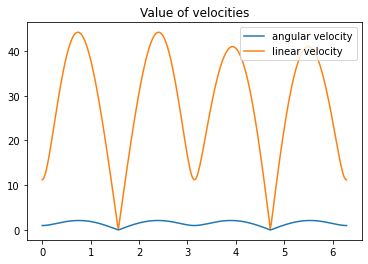

In [14]:
def coord2scalar(coords):
    return [sqrt(x**2 + y**2 + z**2) for x,y,z in coords]

plt.plot(x, coord2scalar(ang_vel), label='angular velocity')
plt.plot(x, coord2scalar(lin_vel), label='linear velocity')
plt.title("Value of velocities")
plt.legend(loc='upper right')
plt.show()

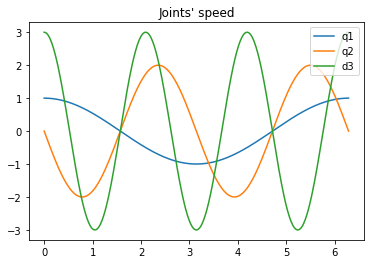

In [15]:
for l, label in zip(np.concatenate(dQs, axis=1), ['q1', 'q2', 'd3']):
    plt.plot(x, l, label=label)
    
plt.title("Joints' speed")
plt.legend(loc='upper right')
plt.show()

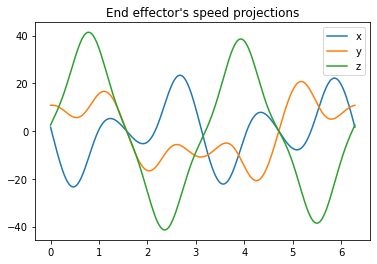

In [16]:
for l, label in zip(np.concatenate(dXs, axis=1), 'xyz'):
    plt.plot(x, l, label=label)
    
plt.title("End effector's speed projections")
plt.legend(loc='upper right')
plt.show()

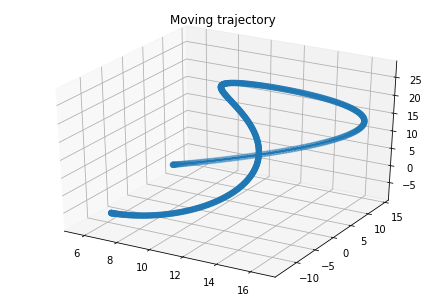

In [17]:
points = np.array(coords)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(points[:,0],points[:,1],points[:,2],s=30)
ax.plot(points[:,0],points[:,1],points[:,2])
plt.title("Moving trajectory")
plt.show()

Sorry, not enough time for animation :c